# 1/ Importation des packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, BaseCrossValidator
from sklearn.preprocessing import MinMaxScaler

import os
import statsmodels.api as sm

from statsmodels.tsa.statespace.sarimax import SARIMAX

import itertools
from datetime import datetime, timedelta


from matplotlib.dates import YearLocator
from pandas.plotting import register_matplotlib_converters


from sklearn.linear_model import LinearRegression

import random as rd

# 2/ Déclaration des constantes

In [61]:
INPUT_PATH = 'C:/Users/guillaume.besson/Optimind/Expertise Center - EC Data Valuation/2. Documents de travail/2.14 - Risque Climatique/modelisation_temperature/01_données/'
OUTPUT_PATH = 'C://Users//guillaume.besson//Optimind//Expertise Center - EC Data Valuation//2. Documents de travail//2.14 - Risque Climatique//modelisation_temperature//03_outputs//'
OPTIARDOISE = '#5b6163'
OPTIORANGE = '#dd692e'



DATE_BEGIN_TRAIN = '2011-01-01'
DATE_BEGIN_4CAST = '2023-01-01'
DATE_END_4CAST = '2023-03-01'

ENDOG_NAME = 'SWI_UNIF_MENS3'
EXOG_NAMES_FULL = ['precip_pluie_mois_agg', 'precip_neige_mois_agg', 'tminj_agg', 'tmaxj_agg', 'tmoyj_agg']
#EXOG_NAMES = ['precip_pluie_mois_agg', 'tminj_agg', 'tmaxj_agg']
EXOG_NAMES = ['precip_pluie_mois_agg', 'precip_neige_mois_agg', 'tminj_agg', 'tmaxj_agg', 'tmoyj_agg']


# 3/ Importation des inputs

In [4]:
df_26 = pd.read_csv(r"C:\Users\guillaume.besson\OneDrive - Optimind\EC Data Valuation\2. Documents de travail\2.14 - Risque Climatique\modelisation_temperature\03_outputs\meteo_agg_2.6.csv")
df_ref = pd.read_csv(r"C:\Users\guillaume.besson\OneDrive - Optimind\EC Data Valuation\2. Documents de travail\2.14 - Risque Climatique\modelisation_temperature\03_outputs\meteo_agg_ref.csv")
df_concat = pd.concat([df_26, df_ref], ignore_index=True)

df_85 = pd.read_csv(r"C:\Users\guillaume.besson\OneDrive - Optimind\EC Data Valuation\2. Documents de travail\2.14 - Risque Climatique\modelisation_temperature\03_outputs\meteo_agg_8.5.csv")


On va joindre les données des mesures au mapping créé dans le script 02. Ainsi, chaque station est raccordée à un barycentre de département.

# 4/ Traitements des données 

## Raccordement de chaque point de mesure au barycentre de département le plus proche

In [5]:
mapping = pd.read_csv(r"C:\Users\guillaume.besson\OneDrive - Optimind\EC Data Valuation\2. Documents de travail\2.14 - Risque Climatique\modelisation_temperature\03_outputs\mapping_mesures_barycentre.csv")

df_concat['lat'] = df_concat['lat'].round(3)
df_concat['lon'] = df_concat['lon'].round(3)
df_85['lat'] = df_85['lat'].round(3)
df_85['lon'] = df_85['lon'].round(3)


mapping['lat_dg'] = mapping['lat_dg'].round(3)
mapping['lon_dg'] = mapping['lon_dg'].round(3)

df_concat['lat'] = df_concat['lat'].astype(str)
df_concat['lon'] = df_concat['lon'].astype(str)
df_85['lat'] = df_85['lat'].astype(str)
df_85['lon'] = df_85['lon'].astype(str)

mapping['lat_dg'] = mapping['lat_dg'].astype(str)
mapping['lon_dg'] = mapping['lon_dg'].astype(str)

merged_df = pd.merge(df_concat, mapping, 
                     left_on=['lat', 'lon'], 
                     right_on=['lat_dg', 'lon_dg'], 
                     how='left')

merged_df_85 = pd.merge(df_85, mapping, 
                     left_on=['lat', 'lon'], 
                     right_on=['lat_dg', 'lon_dg'], 
                     how='left')

merged_df.loc[merged_df['lat_dg'].isna(), 'lat'].unique()



array([], dtype=object)

## La variable réponse (SWI) figure dans d'autres fichier, il fau tdonc les joindre aux données exogènes

In [6]:
swi = pd.read_csv(r"C:\Users\guillaume.besson\OneDrive - Optimind\EC Data Valuation\2. Documents de travail\2.14 - Risque Climatique\modelisation_temperature\03_outputs\SWI.csv", sep = ",")
swi = swi.drop('Unnamed: 0',axis=1)

swi['num_maille'] = swi['num_maille'].astype(str).str.zfill(4)
swi['num_maille'] = swi['num_maille'].astype(str)
swi['DATE'] = swi['DATE'].astype(str)

merged_df['DATE'] = merged_df['cle'].str[-6:]
merged_df['num_maille'] = merged_df['num_maille'].astype(str).str.zfill(4)
merged_df['num_maille'] = merged_df['num_maille'].astype(str)
merged_df['DATE'] = merged_df['DATE'].astype(str)

merged_df_85['DATE'] = merged_df_85['cle'].str[-6:]
merged_df_85['num_maille'] = merged_df_85['num_maille'].astype(str).str.zfill(4)
merged_df_85['num_maille'] = merged_df_85['num_maille'].astype(str)
merged_df_85['DATE'] = merged_df_85['DATE'].astype(str)


merged_df_complet =pd.merge(merged_df, swi[['DATE', 'num_maille', 'SWI_UNIF_MENS3']], how = 'left', on = ['num_maille', 'DATE'])
merged_df_complet['lat'] = merged_df_complet['lat'].astype(float)
merged_df_complet['lon'] = merged_df_complet['lon'].astype(float)

merged_df_complet_85 =pd.merge(merged_df_85, swi[['DATE', 'num_maille', 'SWI_UNIF_MENS3']], how = 'left', on = ['num_maille', 'DATE'])
merged_df_complet_85['lat'] = merged_df_complet_85['lat'].astype(float)
merged_df_complet_85['lon'] = merged_df_complet_85['lon'].astype(float)

## Agrégation des observation à la maille département X mois

In [21]:
aggregated_df = merged_df_complet.drop(columns = ['cle','num_maille', 'lat_dg', 'lon_dg']).groupby(['DATE', 'barycentre_plus_proche']).agg({
    # Spécifiez les colonnes que vous souhaitez agréger et les fonctions d'agrégation nécessaires
    'precip_pluie_mois_agg': 'mean', 
    'precip_neige_mois_agg': 'mean', 
    'lat': 'mean', 
    'lon': 'mean',
    'tminj_agg' : 'min', 
    'tmaxj_agg': 'max', 
    'tmoyj_agg': 'mean', 
    'SWI_UNIF_MENS3' : 'mean'}
    ).reset_index()
aggregated_df['DATE'] = pd.to_datetime(aggregated_df['DATE'], format='%Y%m')
aggregated_df.set_index('DATE', inplace = True, drop = False)

aggregated_df_85 = merged_df_complet_85.drop(columns = ['cle','num_maille', 'lat_dg', 'lon_dg']).groupby(['DATE', 'barycentre_plus_proche']).agg({
    # Spécifiez les colonnes que vous souhaitez agréger et les fonctions d'agrégation nécessaires
    'precip_pluie_mois_agg': 'mean', 
    'precip_neige_mois_agg': 'mean', 
    'lat': 'mean', 
    'lon': 'mean',
    'tminj_agg' : 'min', 
    'tmaxj_agg': 'max', 
    'tmoyj_agg': 'mean', 
    'SWI_UNIF_MENS3' : 'mean'}
    ).reset_index()
aggregated_df_85['DATE'] = pd.to_datetime(aggregated_df_85['DATE'], format='%Y%m')
aggregated_df_85.set_index('DATE', inplace = True, drop = False)

### Liste de tous les départements

In [8]:
DEPARTEMENTS = aggregated_df['barycentre_plus_proche'].unique()

# 5/ Création de quelques fonctions élémentaires de manipulations de dates et de dataframes

In [9]:
def plus_un_mois(date):
    """
    Ajoute un mois à une date donnée.

    Parameters
    ----------
    date : str or datetime.datetime
        La date à laquelle ajouter un mois. Si une chaîne de caractères est fournie,
        elle doit être au format 'YYYY-MM-DD'.

    Returns
    -------
    pandas.Timestamp
        La date décalée d'un mois avec le premier jour du mois suivant.
    """
    
    if not isinstance(date, datetime):
        date = datetime.strptime(date, '%Y-%m-%d')  

    
    mois_suivant = date.month + 1
    annee_suivante = date.year

    if mois_suivant > 12:
        mois_suivant -= 12
        annee_suivante += 1

    
    date_decalee = datetime(annee_suivante, mois_suivant, 1)

    return pd.Timestamp(date_decalee)



In [10]:
def plus_un_an(date):
    """
    Ajoute un an à une date donnée.

    Parameters
    ----------
    date : str or datetime.datetime
        La date à laquelle ajouter un an. Si une chaîne de caractères est fournie,
        elle doit être au format 'YYYY-MM-DD'.

    Returns
    -------
    pandas.Timestamp
        La date décalée d'un an avec le même mois et jour que la date originale.
    """
    
    if not isinstance(date, datetime):
        date = datetime.strptime(date, '%Y-%m-%d')  

    
    date_decalee = datetime(date.year + 1, date.month, date.day)

    return pd.Timestamp(date_decalee)


In [11]:
def supprimer_premiere_ligne(df):
    """
    Supprime la première ligne d'un DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        Le DataFrame à modifier.

    Returns
    -------
    pandas.DataFrame
        Le DataFrame avec la première ligne supprimée.
    """
    return df.iloc[1:]

In [12]:
def supprimer_derniere_ligne(df):
    """
    Supprime la dernière ligne d'un DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        Le DataFrame à modifier.

    Returns
    -------
    pandas.DataFrame
        Le DataFrame avec la dernière ligne supprimée.
    """
    return df.iloc[:-1]

In [13]:
def ajouter_derniere_ligne(df, vect):
    """
    Ajoute une ligne à la fin d'un DataFrame à partir d'un vecteur donné.

    Parameters
    ----------
    df : pandas.DataFrame
        Le DataFrame auquel ajouter une ligne.
    vect : pandas.Series or list
        Le vecteur contenant les valeurs de la nouvelle ligne.

    Returns
    -------
    pandas.DataFrame
        Le DataFrame avec la nouvelle ligne ajoutée à la fin.
    """
    return df.append(pd.Series(vect.values[0], index=df.columns), ignore_index=True)

In [14]:
def nouvelle_base_train(df, vect):
    """
    Supprime la première ligne et ajoute une nouvelle ligne à la fin du DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        Le DataFrame à modifier.
    vect : pandas.Series or list
        Le vecteur contenant les valeurs de la nouvelle ligne à ajouter.

    Returns
    -------
    pandas.DataFrame
        Le DataFrame modifié avec la première ligne supprimée et la nouvelle ligne ajoutée à la fin.
    """
    return ajouter_derniere_ligne(supprimer_premiere_ligne(df), vect)

# 6/ Modélisation

In [15]:
def find_optimal_sarimax_params(df, endog_name, exog_names, p_range, d_range, q_range, P_range, D_range, Q_range, s_range, trends):
    best_aic = float('inf')
    best_params = None

    # Iterate over all combinations of parameters
    for p, d, q, P, D, Q, s, trend in itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range, s_range, trends):
        try:
            # Fit SARIMAX model
            model = sm.tsa.SARIMAX(df[endog_name], exog=df[exog_names], order=(p, d, q), seasonal_order=(P, D, Q, s), trend=trend)
            results = model.fit()

            # Check AIC
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (p, d, q, P, D, Q, s, trend)

        except:
            continue

    return best_params, best_aic


In [16]:
aggregated_df

,DATE,barycentre_plus_proche,precip_pluie_mois_agg,precip_neige_mois_agg,lat,lon,tminj_agg,tmaxj_agg,tmoyj_agg,SWI_UNIF_MENS3
0,2000-01-01,01,113.803267,44.357326,46.079349,5.394733,-22.03,14.32,-0.066185,1.335279
1,2000-01-01,02,67.125475,7.339254,49.591898,3.536364,-8.77,13.07,2.809776,0.976178
2,2000-01-01,03,71.404419,21.353316,46.399709,3.210786,-13.19,15.76,1.920240,0.912932
3,2000-01-01,04,22.082889,6.507356,44.095956,6.198989,-20.42,16.53,-0.242007,1.134800
4,2000-01-01,05,52.521692,44.393364,44.713299,6.373626,-28.13,16.58,-4.112623,1.147579
...,...,...,...,...,...,...,...,...,...,...
29947,2030-12-01,91,68.297568,1.243091,48.431068,2.226523,-3.20,14.89,6.270279,NaN
29948,2030-12-01,92,60.348000,0.251222,48.823222,2.174000,-2.56,16.32,7.064229,NaN
29949,2030-12-01,93,72.443500,0.740962,49.029923,2.749423,-3.67,15.91,6.586439,NaN
29950,2030-12-01,94,59.482308,0.445692,48.723692,2.533692,-2.79,15.23,6.816030,NaN


# Define ranges for parameters
p_range = range(1)
d_range = range(1)
q_range = range(1)
P_range = range(2)
D_range = range(2)
Q_range = range(2)
s_range = range(3)  # Assuming seasonality goes from 0 to 11
trends = ['ct']

# Call the function
best_params, best_aic = find_optimal_sarimax_params(aggregated_df, 'SWI_UNIF_MENS3', EXOG_NAMES, p_range, d_range, q_range, P_range, D_range, Q_range, s_range, trends)

print("Best SARIMAX parameters:", best_params)
print("Best AIC:", best_aic)

In [17]:
def fit_sarimax_model(df, endog_name, exog_names, order, seasonal_order, trend='c'):
    """
    Fit SARIMAX model to the provided data.
    
    Parameters:
        df (DataFrame): The DataFrame containing the data.
        endog_name (str): The name of the endogenous variable.
        exog_names (list): A list of names of the exogenous variables.
        order (tuple): The (p, d, q) order of the non-seasonal ARIMA component.
        seasonal_order (tuple): The (P, D, Q, S) seasonal order of the ARIMA component.
        trend (str): The trend parameter of the SARIMAX model. Default is 'c' (constant).
    
    Returns:
        SARIMAXResultsWrapper: The fitted SARIMAX model results.
    """
    # Create SARIMAX model
    model = sm.tsa.SARIMAX(df[endog_name], exog=df[exog_names], order=order, seasonal_order=seasonal_order, trend=trend)
    
    # Fit the model
    results = model.fit()
    
    return results

In [70]:
dept = '01'

# SCENARION DE REFERENCE

c:\Users\guillaume.besson\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\guillaume.besson\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\guillaume.besson\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\guillaume.besson\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization fail

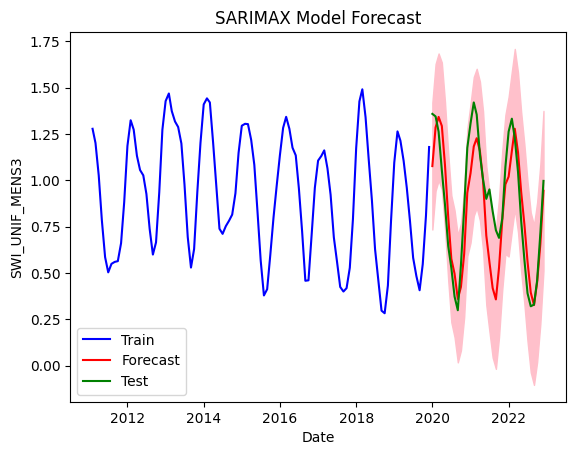

In [24]:
# Données d'apprentissage jusqu'en janvier 2017
train_data = aggregated_df[(aggregated_df['barycentre_plus_proche'] == '01') & 
                           (aggregated_df['DATE'] > '2011-01-01') & 
                           (aggregated_df['DATE'] < '2020-01-01')]

# Données de test de janvier 2017 à janvier 2019
test_data = aggregated_df[(aggregated_df['barycentre_plus_proche'] == '01') & 
                          (aggregated_df['DATE'] >= '2020-01-01') & 
                          (aggregated_df['DATE'] < '2023-01-01')]

# Ajuster le modèle SARIMAX avec les données d'entraînement
sarimax_model = fit_sarimax_model(train_data, 'SWI_UNIF_MENS3', EXOG_NAMES, 
                                  order=(0, 0, 0), seasonal_order=(10, 1, 0, 12))

# Faire des prédictions pour la période de test
forecast = sarimax_model.get_prediction(start='2020-01-01', end='2022-12-01', exog=test_data[EXOG_NAMES])

# Tracer les valeurs observées jusqu'en janvier 2017
plt.plot(train_data['DATE'], train_data['SWI_UNIF_MENS3'], label='Train', color='blue')

# Tracer les valeurs prédites pour la période de test
forecast_ci = forecast.conf_int()
plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')

# Tracer les valeurs observées pour la période de test
plt.plot(test_data['DATE'], test_data['SWI_UNIF_MENS3'], label='Test', color='green')

# Configurer les étiquettes et le titre
plt.xlabel('Date')
plt.ylabel('SWI_UNIF_MENS3')
plt.title('SARIMAX Model Forecast')

# Légende
plt.legend()

# Afficher le graphique
plt.show()

param optimaux pour l'instant : 
order=(0, 0, 0), seasonal_order=(10, 1, 0, 12))

# PROJECTION LOINTAINE

c:\Users\guillaume.besson\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\guillaume.besson\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\guillaume.besson\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\guillaume.besson\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization fail

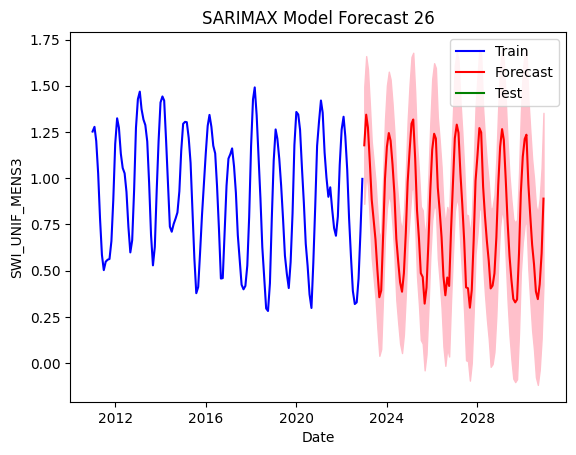

In [56]:
# Données d'apprentissage jusqu'en janvier 2017
train_data_26 = aggregated_df[(aggregated_df['barycentre_plus_proche'] == '01') & 
                           (aggregated_df['DATE'] >= '2011-01-01') & 
                           (aggregated_df['DATE'] < '2023-01-01')]

# Données de test de janvier 2017 à janvier 2019
test_data_26 = aggregated_df[(aggregated_df['barycentre_plus_proche'] == '01') & 
                          (aggregated_df['DATE'] >= '2023-01-01') & 
                          (aggregated_df['DATE'] < '2031-01-01')]

# Ajuster le modèle SARIMAX avec les données d'entraînement
sarimax_model = fit_sarimax_model(train_data_26, 'SWI_UNIF_MENS3', EXOG_NAMES, 
                                  order=(0, 0, 0), seasonal_order=(12, 1, 1, 12))

# Faire des prédictions pour la période de test
forecast_26 = sarimax_model.get_prediction(start='2023-01-01', end='2030-12-01', exog=test_data_26[EXOG_NAMES])

# Tracer les valeurs observées jusqu'en janvier 2017
plt.plot(train_data_26['DATE'], train_data_26['SWI_UNIF_MENS3'], label='Train', color='blue')

# Tracer les valeurs prédites pour la période de test
forecast_ci_26 = forecast_26.conf_int()
plt.plot(forecast_26.predicted_mean.index, forecast_26.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci_26.index, forecast_ci_26.iloc[:, 0], forecast_ci_26.iloc[:, 1], color='pink')

# Tracer les valeurs observées pour la période de test
plt.plot(test_data_26['DATE'], test_data_26['SWI_UNIF_MENS3'], label='Test', color='green')

# Configurer les étiquettes et le titre
plt.xlabel('Date')
plt.ylabel('SWI_UNIF_MENS3')
plt.title('SARIMAX Model Forecast 26')

# Légende
plt.legend()

# Afficher le graphique
plt.show()

In [57]:
test_data_26 = aggregated_df[(aggregated_df['barycentre_plus_proche'] == '01') & 
                          (aggregated_df['DATE'] >= '2023-01-01') & 
                          (aggregated_df['DATE'] < '2031-01-01')]
test_data_26['SWI_UNIF_MENS3'] = forecast_26.predicted_mean.values
test_data_26

C:\Users\guillaume.besson\AppData\Local\Temp\ipykernel_27604\1200222449.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_26['SWI_UNIF_MENS3'] = forecast_26.predicted_mean.values


,DATE,barycentre_plus_proche,precip_pluie_mois_agg,precip_neige_mois_agg,lat,lon,tminj_agg,tmaxj_agg,tmoyj_agg,SWI_UNIF_MENS3
DATE,,,,,,,,,,
2023-01-01,2023-01-01,01,158.114802,12.016151,46.079349,5.394733,-13.19,16.86,3.090476,1.177993
2023-02-01,2023-02-01,01,136.851314,49.822663,46.079349,5.394733,-11.48,14.34,1.577375,1.343577
2023-03-01,2023-03-01,01,139.849349,7.999430,46.079349,5.394733,-16.71,23.55,7.914486,1.273966
2023-04-01,2023-04-01,01,98.697221,5.573779,46.079349,5.394733,-6.70,26.05,9.228453,1.084447
2023-05-01,2023-05-01,01,90.257651,0.070756,46.079349,5.394733,-1.29,29.35,14.670469,0.884213
...,...,...,...,...,...,...,...,...,...,...
2030-08-01,2030-08-01,01,49.444453,0.000000,46.079349,5.394733,7.56,38.77,23.134074,0.387519
2030-09-01,2030-09-01,01,172.883884,0.004151,46.079349,5.394733,3.14,31.95,16.545120,0.346144
2030-10-01,2030-10-01,01,83.993140,0.395198,46.079349,5.394733,-2.94,26.01,8.366485,0.426697


In [60]:
df_output_26_01 = pd.concat([train_data_26, test_data_26])
#df_output_26_01.groupby(df_output_26_01['DATE'].dt.year)['DATE'].count()


In [68]:
df_output_26_01.to_csv(r'C:\Users\guillaume.besson\OneDrive - Optimind\EC Data Valuation\2. Documents de travail\2.14 - Risque Climatique\modelisation_temperature\03_outputs\Hackathon\df_output_26_01.csv')

C://Users//guillaume.besson//Optimind//Expertise Center - EC Data Valuation//2. Documents de travail//2.14 - Risque Climatique//modelisation_temperature//03_outputs//


# SCENARIO PESSIMISTE 8.5

print(min(aggregated_df_85['DATE']), max(aggregated_df_85['DATE']))


aggregated_df_85.groupby(aggregated_df_85['DATE'].dt.year)['DATE'].count()
#print(aggregated_df)
#aggregated_df_85

In [31]:
#la prédiciton qui manque, qui va être ajoutée à train_85, pour avoir dans le train l'annnée 2023 en 85
dtt = aggregated_df[(aggregated_df['DATE'] < pd.to_datetime('2024-01-01')) & \
                                            (aggregated_df['DATE'] >= pd.to_datetime('2023-01-01')) & \
                                                (aggregated_df['barycentre_plus_proche'] == '01')]
forecast_2023 = sarimax_model.get_prediction(start='2023-01-01', end='2023-12-01', exog=dtt[EXOG_NAMES])
dtt[ENDOG_NAME] = forecast_2023.predicted_mean.values
print(dtt)

                 DATE barycentre_plus_proche  precip_pluie_mois_agg  \
DATE                                                                  
2023-01-01 2023-01-01                     01             158.114802   
2023-02-01 2023-02-01                     01             136.851314   
2023-03-01 2023-03-01                     01             139.849349   
2023-04-01 2023-04-01                     01              98.697221   
2023-05-01 2023-05-01                     01              90.257651   
2023-06-01 2023-06-01                     01             118.419930   
2023-07-01 2023-07-01                     01              83.610093   
2023-08-01 2023-08-01                     01               5.882012   
2023-09-01 2023-09-01                     01             101.361488   
2023-10-01 2023-10-01                     01              64.470628   
2023-11-01 2023-11-01                     01             147.427930   
2023-12-01 2023-12-01                     01              74.373767   

     

C:\Users\guillaume.besson\AppData\Local\Temp\ipykernel_27604\2444278277.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtt[ENDOG_NAME] = forecast_2023.predicted_mean.values


In [33]:
train_data_85 = pd.concat([train_data_26, dtt])
print(train_data_85)

                 DATE barycentre_plus_proche  precip_pluie_mois_agg  \
DATE                                                                  
2011-01-01 2011-01-01                     01             113.668302   
2011-02-01 2011-02-01                     01              46.578000   
2011-03-01 2011-03-01                     01              69.909337   
2011-04-01 2011-04-01                     01              80.767674   
2011-05-01 2011-05-01                     01             107.651000   
...               ...                    ...                    ...   
2023-08-01 2023-08-01                     01               5.882012   
2023-09-01 2023-09-01                     01             101.361488   
2023-10-01 2023-10-01                     01              64.470628   
2023-11-01 2023-11-01                     01             147.427930   
2023-12-01 2023-12-01                     01              74.373767   

            precip_neige_mois_agg        lat       lon  tminj_agg  tmaxj_agg

In [34]:
train_data_85.groupby(train_data_85['DATE'].dt.year)['DATE'].count()

DATE
2011    12
2012    12
2013    12
2014    12
2015    12
2016    12
2017    12
2018    12
2019    12
2020    12
2021    12
2022    12
2023    12
Name: DATE, dtype: int64

c:\Users\guillaume.besson\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\guillaume.besson\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\guillaume.besson\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\guillaume.besson\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization fail

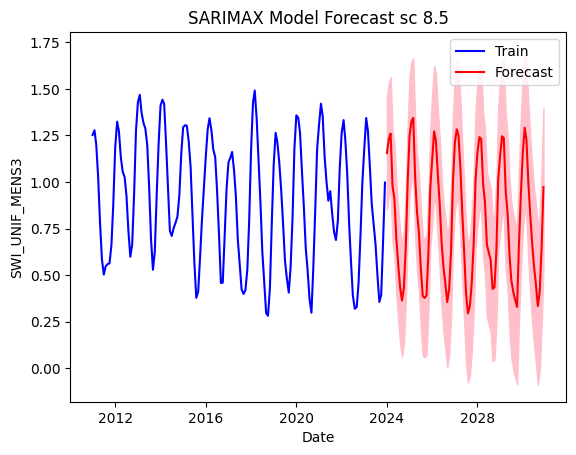

In [35]:

# Données de test de janvier 2017 à janvier 2019
test_data_85 = aggregated_df_85[(aggregated_df_85['barycentre_plus_proche'] == '01') & 
                          (aggregated_df_85['DATE'] >= '2024-01-01') & 
                          (aggregated_df_85['DATE'] < '2031-01-01')]

# Ajuster le modèle SARIMAX avec les données d'entraînement
sarimax_model = fit_sarimax_model(train_data_85, 'SWI_UNIF_MENS3', EXOG_NAMES, 
                                  order=(0, 0, 0), seasonal_order=(12, 1, 1, 12))

# Faire des prédictions pour la période de test
forecast_85 = sarimax_model.get_prediction(start='2024-01-01', end='2030-12-01', exog=test_data_85[EXOG_NAMES])

# Tracer les valeurs observées jusqu'en janvier 2017
plt.plot(train_data_85['DATE'], train_data_85['SWI_UNIF_MENS3'], label='Train', color='blue')

# Tracer les valeurs prédites pour la période de test
forecast_ci_85 = forecast_85.conf_int()
plt.plot(forecast_85.predicted_mean.index, forecast_85.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci_85.index, forecast_ci_85.iloc[:, 0], forecast_ci_85.iloc[:, 1], color='pink')



# Configurer les étiquettes et le titre
plt.xlabel('Date')
plt.ylabel('SWI_UNIF_MENS3')
plt.title('SARIMAX Model Forecast sc 85')

# Légende
plt.legend()

# Afficher le graphique
plt.show()

In [47]:
test_data['SWI_UNIF_MENS3'] = forecast.predicted_mean.values

C:\Users\guillaume.besson\AppData\Local\Temp\ipykernel_27604\1424346581.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['SWI_UNIF_MENS3'] = forecast.predicted_mean.values


In [51]:
df_output_85_01 = pd.concat([train_data_bis, test_data])

In [69]:
df_output_85_01.to_csv(r'C:\Users\guillaume.besson\OneDrive - Optimind\EC Data Valuation\2. Documents de travail\2.14 - Risque Climatique\modelisation_temperature\03_outputs\Hackathon\df_output_85_01.csv')

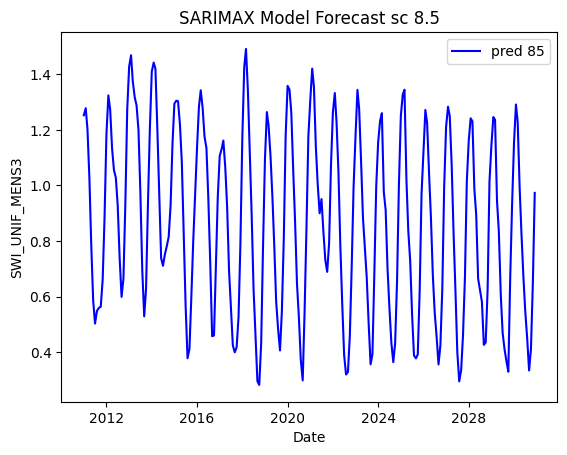

In [54]:
plt.plot(df_output_85_01['DATE'], df_output_85_01['SWI_UNIF_MENS3'], label='pred 85', color='blue')


# Configurer les étiquettes et le titre
plt.xlabel('Date')
plt.ylabel('SWI_UNIF_MENS3')
plt.title('SARIMAX Model Forecast sc 8.5')

# Légende
plt.legend()

# Afficher le graphique
plt.show()

In [125]:
def fit_arimax_with_optimal_order(df, n_order, N_order, tendances, saisonnalite):
    """
    Ajuste un modèle ARIMAX avec les ordres optimaux sélectionnés en fonction du critère AIC.

    Parameters
    ----------
    df : DataFrame
        DataFrame contenant à la fois la variable endogène et les variables exogènes.
    n_order : int
        L'ordre max des paramètres de tendance (p, d, q) du modèle SARIMAX à ajuster.
    N_order : int
        L'ordre max des paramètres de saisonnalité (P, D, Q) du modèle SARIMAX à ajuster.
    tendances : list
        Vecteur des tendances à tester.
    saisonnalité : list
        Vecteur des saisonnalités (s) à tester.

    Returns
    -------
    SARIMAXResultsWrapper
        Résultats de l'ajustement du modèle SARIMAX.
    """
    
    # Define other ranges
    p_range = range(1)
    d_range = range(1)
    q_range = range(1)
    P_range = range(1)
    D_range = range(1)
    Q_range = range(1)
    trends = ['n']

    saisonnalite = 6

    aic_results = []

    for p, d, q, P, D, Q, s, trend in itertools.product(p_range, d_range, q_range, P_range, D_range, Q_range, saisonnalite, trends):
        
        model = sm.tsa.SARIMAX(df[ENDOG_NAME], exog=df[EXOG_NAMES], order=(p, d, q), seasonal_order=(P, D, Q, s), trend=trend)
        try:
            results = model.fit()
            
            aic_results.append((results.aic, (p, d, q, P, D, Q, s, trend)))
            print(aic_results)
        except:
            
            continue

    if not aic_results:
        raise ValueError("Aucune combinaison valide trouvée pour ajuster le modèle.")

    
    best_aic, best_orders = min(aic_results)
    
    best_p, best_d, best_q, best_P, best_D, best_Q, best_s, best_trend = best_orders

    
    optimal_model = sm.tsa.SARIMAX(df[ENDOG_NAME], exog=df[EXOG_NAMES], order=(best_p, best_d, best_q), 
                                   seasonal_order=(best_P, best_D, best_Q, best_s))
    optimal_results = optimal_model.fit()
    return optimal_results



In [111]:
#POur le scénatio 8.5, données qu'à partir de 2024
aggregated_df_85 = aggregated_df_85[aggregated_df_85['DATE'] > '2012-01-01']

In [113]:
fit_arimax_with_optimal_order(aggregated_df[(aggregated_df['barycentre_plus_proche'] == '01') & (aggregated_df['DATE'] < pd.to_datetime('2016-01-01'))], 
                               1,1,['n'],[2])   

c:\Users\guillaume.besson\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\guillaume.besson\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


[(43.37307875331386, (0, 0, 0, 0, 0, 0, 2, 'n'))]


c:\Users\guillaume.besson\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\guillaume.besson\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [114]:
def sliding_4cast(data, dpt, n_order, N_order, tendances, saisonnalite, sclr, output_path, 
                  date_begin_train = DATE_BEGIN_TRAIN, date_begin_4cast = DATE_BEGIN_4CAST, date_end_4cast = DATE_END_4CAST):
    """
    Réalise une prévision glissante sur les données temporelles.

    Parameters
    ----------
    data : pandas.DataFrame
        Le DataFrame contenant les données temporelles.
    dpt : str
        Le département sur lequel effectuer la prévision.
    n_order : int
        L'ordre max des paramètres de tendance (p, d, q) du modèle SARIMAX à ajuster.
    N_order : int
        L'ordre max des paramètres de saisonnalité (P, D, Q,s) du modèle SARIMAX à ajuster.
    tendances : list
        Vecteur des tendances à tester.
    saisonnalité : list
        Vecteur des saisonnalités (s) à tester.    
    sclr : Function
        Fonction utilsée pour la normalisation des données d'entraînement.
    output_path : str
        Chemin d'emplacement des outputs.
    date_begin_4cast : str
        Date à partir de laquelle est calibrée le modèle.    
    date_begin_4cast : str
        Date du mois à prévoir.
    date_end_4cast : str
        Date jusqu'à laquelle les prédictions sont réalisées.
    Returns
    -------
    None
        La fonction sauvegarde les résultats de la prévision dans un fichier CSV.
    """
    nb_iter = 0

    print('nb_iter : ', nb_iter)
    print('______')
    
    date_debut_entrainement, date_debut_4cast, date_fin_4cast = pd.to_datetime(date_begin_train), pd.to_datetime(date_begin_4cast), plus_un_mois(pd.to_datetime(date_begin_4cast))
    print('date_debut_4cast : ', date_debut_4cast)
    data_travail = data.copy()

    scaler = sclr
    
    data_travail = data_travail[(data_travail['barycentre_plus_proche'] == dpt)]

    data_train = data_travail.copy()
    data_pred = data_travail[(data_travail['DATE'] == date_debut_4cast)]
    data_train = data_train[(data_train['DATE'] >= date_debut_entrainement) & (data_train['DATE'] < date_debut_4cast)]

    data_train.set_index('DATE', inplace=True, drop=False)
    data_pred.set_index('DATE', inplace=True, drop=False)

    data_train[EXOG_NAMES] = scaler.fit_transform(data_train[EXOG_NAMES])
    data_pred[EXOG_NAMES] = scaler.transform(data_pred[EXOG_NAMES])

    fitted_model = fit_arimax_with_optimal_order(data_train, n_order, N_order, tendances, saisonnalite)
    forecast = fitted_model.predict(start=date_debut_4cast, end=date_debut_4cast, exog=data_pred[EXOG_NAMES])
    data_pred[ENDOG_NAME] = forecast

    data_pred[EXOG_NAMES] = scaler.inverse_transform(data_pred[EXOG_NAMES])
    data_train[EXOG_NAMES] = scaler.inverse_transform(data_train[EXOG_NAMES])
    data_travail = ajouter_derniere_ligne(data_travail, data_pred)
    data = ajouter_derniere_ligne(data, data_pred)

    data_train = pd.concat([data_train, data_pred])

    
    while date_debut_4cast < pd.to_datetime(date_end_4cast):
        nb_iter += 1
        print('nb_iter : ', nb_iter)
        print('______')
        


        date_debut_entrainement, date_debut_4cast, date_fin_4cast = plus_un_mois(date_debut_entrainement), \
                                plus_un_mois(date_debut_4cast), plus_un_mois(date_fin_4cast) 
        print('date_debut_4cast : ', date_debut_4cast)
        data_pred = data_travail[(data_travail['DATE'] == date_debut_4cast)]

        data_train = nouvelle_base_train(data_train, data_pred)
        data_train.set_index('DATE', inplace=True, drop=False)
        data_pred.set_index('DATE', inplace=True, drop=False)
        data_train[EXOG_NAMES] = scaler.fit_transform(data_train[EXOG_NAMES])
        data_pred[EXOG_NAMES] = scaler.transform(data_pred[EXOG_NAMES])

        fitted_model = fit_arimax_with_optimal_order(data_train, n_order, N_order, tendances, saisonnalite)      
        forecast = fitted_model.predict(start=date_debut_4cast, end=date_debut_4cast, exog=data_pred[EXOG_NAMES])
        data_pred[ENDOG_NAME] = forecast
        data_pred[EXOG_NAMES] = scaler.inverse_transform(data_pred[EXOG_NAMES])
        data_train[EXOG_NAMES] = scaler.inverse_transform(data_train[EXOG_NAMES])

        data = ajouter_derniere_ligne(data, data_pred)
        
        
        data_train = pd.concat([data_train, data_pred])
        

    df_res = data[(data['barycentre_plus_proche'] == dpt) & (data['DATE'] >= date_begin_train)].sort_values('DATE')
    df_res = df_res.dropna(subset=[ENDOG_NAME])
    
    
    df_res.to_csv(output_path+ "4cast_pdq_PDQ_season_trend_" + str(n_order) + "_" + str(dpt) + ".csv", index=False)





In [126]:
sliding_4cast(aggregated_df,'01',1,1, 'n', 1, MinMaxScaler(), 'C:\\Users\\guillaume.besson\\OneDrive - Optimind\\Bureau\\', 
                  date_begin_train = '2011-01-01', date_begin_4cast = '2017-01-01', date_end_4cast = '2017-12-31')

nb_iter :  0
______
date_debut_4cast :  2017-01-01 00:00:00


C:\Users\guillaume.besson\AppData\Local\Temp\ipykernel_25864\1510357645.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pred[EXOG_NAMES] = scaler.transform(data_pred[EXOG_NAMES])


TypeError: 'int' object is not iterable

In [116]:
def fit_arimax_with_optimal_order_draft(df, n_order):
    """
    Ajuste un modèle ARIMAX avec les ordres optimaux sélectionnés en fonction du critère AIC.

    Parameters
    ----------
    df : DataFrame
        DataFrame contenant à la fois la variable endogène et les variables exogènes.
    n_order : int
        L'ordre max des paramètres de tendance (p, d, q) du modèle SARIMAX à ajuster.
    N_order : int
        L'ordre max des paramètres de saisonnalité (P, D, Q) du modèle SARIMAX à ajuster.
    tendances : list
        Vecteur des tendances à tester.
    saisonnalité : list
        Vecteur des saisonnalités (s) à tester.

    Returns
    -------
    SARIMAXResultsWrapper
        Résultats de l'ajustement du modèle SARIMAX.
    """
    
    p_range = range(0, n_order)
    d_range = range(0, n_order)
    q_range = range(0, n_order)

    aic_results = []

    for p, d, q in itertools.product(p_range, d_range, q_range):
        
        model = sm.tsa.SARIMAX(df[ENDOG_NAME], exog=df[EXOG_NAMES], order=(p, d, q))
        try:
            results = model.fit()
            
            aic_results.append((results.aic, (p, d, q)))
            #print(aic_results)
        except:
            
            continue

    if not aic_results:
        raise ValueError("Aucune combinaison valide trouvée pour ajuster le modèle.")

    
    best_aic, best_orders = min(aic_results)
    
    best_p, best_d, best_q = best_orders

    
    optimal_model = sm.tsa.SARIMAX(df[ENDOG_NAME], exog=df[EXOG_NAMES], order=(best_p, best_d, best_q))
    optimal_results = optimal_model.fit()
    return optimal_results


In [85]:
def concatener_csv(chemin_repertoire, nom_fichier_sortie):
    """
    Concatène plusieurs fichiers CSV en un seul fichier CSV.

    Parcourt tous les fichiers CSV dans le répertoire spécifié et les fusionne
    en un seul DataFrame, puis écrit ce DataFrame dans un fichier CSV de sortie.

    Parameters
    ----------
    chemin_repertoire : str
        Chemin du répertoire contenant les fichiers CSV à concaténer.
    nom_fichier_sortie : str, optional
        Nom du fichier de sortie pour le CSV concaténé. Par défaut, 'fusion.csv'.

    Returns
    -------
    None
        La fonction écrit le fichier CSV concaténé dans le répertoire spécifié.

    Raises
    ------
    FileNotFoundError
        Si aucun fichier CSV n'est trouvé dans le répertoire spécifié.
    """

    list_df = []

    
    for fichier in os.listdir(chemin_repertoire):
        if fichier.endswith('.csv'):
            chemin_fichier = os.path.join(chemin_repertoire, fichier)
            
            df = pd.read_csv(chemin_fichier)
            list_df.append(df)

    
    df_concat = pd.concat(list_df, ignore_index=True)

    
    chemin_sortie = os.path.join(chemin_repertoire, nom_fichier_sortie)

    
    df_concat.to_csv(chemin_sortie, index=False)

    



#df_res.to_csv("C:/Users/pablo.gassiot/OneDrive - Optimind/Bureau/SWI_nouvelle_methode/"+ "4cast_pdq" + str(n_order) +"_" + str(dpt) + ".csv", index=False)


chemin_repertoire = "C:/Users/pablo.gassiot/OneDrive - Optimind/Bureau/SWI_nouvelle_methode/8.5/"
nom_fichier_sortie = '4cast_8.5_pdq1_France.csv'
concatener_csv(chemin_repertoire, nom_fichier_sortie)

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: 'C:/Users/pablo.gassiot/OneDrive - Optimind/Bureau/SWI_nouvelle_methode/8.5/'

In [22]:
import sys
print(sys.version)

3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
